# Usage demonstration of Scipy's `LowLevelCallable` in combination with Cython

Our aim is to speed up the calculation of an exemplary integral with _multiple_ paramters,

$$
I(a, b) = \int_0^\infty \mathrm{d}x\, \frac{x \,\mathrm{e}^{-a x}}{\tanh x} \cos b x \,,
$$

by means of Cython and Scipy's `quad` routine accepting a low-level callback function of type `scipy.LowLevelCallable`.

We show several levels of speed improvements leveraging more and more advanced features of Cython and Scipy.

In [1]:
import math

def integrand(x, params):
    a, b = params['a'], params['b']
    
    if x == 0:
        return 1
    else:
        return x * math.exp(-a*x)/math.tanh(x) * math.cos(b*x)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0, 10, 200)

In [3]:
params = {'a': 1, 'b': 10}

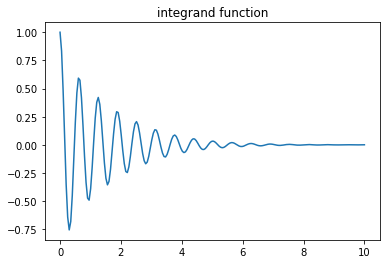

In [4]:
plt.plot(x, [integrand(x_i, params) for x_i in x]); plt.title("integrand function");

## Create an extension module: `module.pyx`

In [29]:
%%writefile module.pyx

cimport cython

from libc.math cimport exp, tanh, cos
from cpython.pycapsule cimport PyCapsule_New

@cython.cdivision(True)
cdef double c_integrand(double x, dict params):
    cdef double a = params['a']
    cdef double b = params['b']
    if x == 0:
        return 1
    else:
        return x * exp(-a*x)/tanh(x) * cos(b*x) 
    
@cython.cdivision(True)
cpdef double cp_integrand(double x, dict params):
    cdef double a = params['a']
    cdef double b = params['b']
    if x == 0:
        return 1
    else:
        return x * exp(-a*x)/tanh(x) * cos(b*x)  
    
cpdef object capsule(double a):
    """Wrap 'a' in a PyCapsule for transport."""
    cdef double* a_ptr = &a
    #a_ptr[0] = a
    return PyCapsule_New(<void*>a_ptr, NULL, NULL)

Overwriting module.pyx


## Create a corresponding declaration file: `module.pxd`

In [30]:
%%writefile module.pxd

cdef double c_integrand(double x, dict params)
cpdef double cp_integrand(double x, dict params)

Overwriting module.pxd


In [31]:
import pyximport; pyximport.install(inplace=True, language_level=3)

(None, None)

In [32]:
import module, os
print("It's an extension module:\n", module.__file__.replace(os.getcwd(), "."))

It's an extension module:
 ./module.cpython-37m-x86_64-linux-gnu.so


In [37]:
dir(module)

['__builtins__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__pyx_capi__',
 '__spec__',
 '__test__',
 'capsule',
 'cp_integrand']

The Cython C/API provides us with two functions:

In [50]:
module.__pyx_capi__

{'c_integrand': <capsule object "double (double, PyObject *)" at 0x7fd4baae7600>,
 'cp_integrand': <capsule object "double (double, PyObject *, int __pyx_skip_dispatch)" at 0x7fd4baae7660>}

In [31]:
import math

from scipy.integrate import quad
from scipy import LowLevelCallable

from module import cp_integrand, capsule

# along to the compiled module, a corresponding .pxd file with declarations is necessary
ll_c_integrand = LowLevelCallable.from_cython(module, 'c_integrand', capsule(params))
ll_cp_integrand = LowLevelCallable.from_cython(module, 'cp_integrand', capsule(params))

# integration limits
lower, upper = 0, math.inf

def integral1():
    return quad(integrand, lower, upper, (params,))

def integral2():
    return quad(cp_integrand, lower, upper, (params,))

def integral3():
    return quad(ll_c_integrand, lower, upper)

def integral4():
    return quad(ll_cp_integrand, lower, upper)

## Timing results

In [32]:
# pure Python version
%timeit integral1()

944 µs ± 57.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [33]:
# Cython version of integrand, passed over to quad as PyObject
%timeit integral2()

257 µs ± 17 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [34]:
# Cython version of integrand, passed over to quad as scipy.LowLevelCallable
%timeit integral3()

ValueError: Invalid scipy.LowLevelCallable signature "double (double, PyObject *)". Expected one of: ['double (double, void *)', 'double (int, double *, void *)', 'double (double)', 'double (int, double *)']

In [ ]:
# LowLevelCallable does not accept cpdef declared functions
try:
    integral4()
except Exception as e:
    print(e)

## Putting integration routine _inside_ a Cython extension module

In [ ]:
%%writefile module_inplace.pxd

cdef double c_integrand(double x)

In [ ]:
%%writefile module_inplace.pyx

import sys

from scipy.integrate import quad
from scipy import LowLevelCallable

from libc.math cimport exp, tanh, cos

# refer to module inside the module itself
current_module = sys.modules[__name__]

cdef double c_integrand(double x):
    if x == 0:
        return 1
    else:
        return x * exp(-x)/tanh(x) * cos(10 * x)  

ll_c_integrand_inside_module = LowLevelCallable.from_cython(current_module, 'c_integrand')

import math
def integral5():
    return quad(ll_c_integrand_inside_module, 0, math.inf)

def integral6():
    return quad(c_integrand, 0, math.inf)

In [ ]:
import pyximport; pyximport.install(inplace=True, language_level=3)

In [ ]:
from module_inplace import integral5, integral6

In [ ]:
%timeit integral5()

In [ ]:
%timeit integral6()

In [ ]:
# final check
np.allclose(integral1(), integral2(), integral3(), integral5())

In [52]:
!rm module*

In [ ]:
%load_ext cython

In [ ]:
%%cython -3

import math
import sys
cimport cython

from libc.math cimport exp, tanh, cos
from scipy.integrate import quad
from scipy import LowLevelCallable

current_module = sys.modules[__name__]

print(current_module.__file__)
print()
print(dir(current_module))

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
# In order to be able to use LowLevelCallable on this function, 
# the api modifier is hugely useful when using %%cython (otherwise a pxd 
# file, sharing the same name as the current module, must be placed inside
# /home/daniel/.cache/ipython/cython/)
cdef api double cc_integrand(double x) nogil:
    if x == 0:
        return 1
    else:
        return x * exp(-x)/tanh(x) * cos(10 * x)  

ll_cc_integrand = LowLevelCallable.from_cython(current_module, 'cc_integrand')
    
def integral7():
    # From Cython documentation: >>Within a Cython module, Python functions and C functions 
    # can call each other freely.<< However, cdef'ed function 'cc_integrand' must internally 
    # be wrapped in order to return an PyObject, when called by a Python function like quad.
    return quad(cc_integrand, 0, math.inf)

def integral8():
    return quad(ll_cc_integrand, 0, math.inf)

In [ ]:
%timeit integral7()

In [ ]:
%timeit integral8()

---

In [ ]:
%%cython -3

import sys
from scipy.integrate import quad
from scipy import LowLevelCallable
from cpython.pycapsule cimport PyCapsule_New
from cpython.ref cimport PyObject

current_module = sys.modules[__name__]

print(current_module.__file__)
print()
print(dir(current_module))

cdef api double c_integrand (double x, void *user_data) nogil:
    #cdef double a = <double>user_data[0]  # void pointer can't be dereferenced and then casted
    cdef double a = (<double*>user_data)[0] # first cast void pointer, then dereference
    return a*x

cdef class Psi:
    cdef double a
    cdef object capsule
    #cdef PyObject* capsule
    cdef object ll_c_integrand
    
    def __init__(self, a):
        self.a = a
        self.capsule = PyCapsule_New(<void*>&self.a, NULL, NULL)
        self.ll_c_integrand = LowLevelCallable.from_cython(current_module, 'c_integrand', self.capsule)
        
    cdef double integrand(self, double x):
        return self.a * x
    
    def integral1(self):      
        #return quad(self.integrand, 0, 1) # does not work with cdef, but with cpdef
        return quad(lambda x : Psi.integrand(self, x), 0, 1) # works with cdef
    
    def integral2(self):
        #capsule = PyCapsule_New(<void*>&self.a, NULL, NULL)
        #ll_c_integrand = LowLevelCallable.from_cython(current_module, 'c_integrand', self.capsule)
        return quad(self.ll_c_integrand, 0, 1)

In [ ]:
psi = Psi(1)

In [ ]:
%timeit psi.integral1()

In [ ]:
%timeit psi.integral2()